In [2]:
# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# navigate to the correct repository
%cd gdrive/My Drive/FONM_Project
! ls

/content/gdrive/.shortcut-targets-by-id/1lpm15jjEIdCXHhtd8FAUljbswyxFuyq_/FONM_Project
Final_Project.ipynb  Project_Report.gdoc  SORN_V2


We download all the required files from the SORN v2 repository at https://github.com/delpapa/SORN_V2

In [ ]:
# clone github repository in gdrive/My Drive/FONM_Project
#! git clone https://github.com/delpapa/SORN_V2.git

In [4]:
# access SORN_V2, the github home repository 
%cd SORN_V2
! ls

/content/gdrive/.shortcut-targets-by-id/1lpm15jjEIdCXHhtd8FAUljbswyxFuyq_/FONM_Project/SORN_V2
backup	      GrammarTask  MemoryAvalanche     RandomSequenceTask  TextTask
common	      imgs	   NeuronalAvalanches  README.md	   utils
CountingTask  LICENSE	   plots	       requirements.txt


In [ ]:
# example, run CountingTask with param as parameters (that file is in CountingTask folder)
# the results are stored in the 'test1_plotting' repository inside backup
! python common/run_single.py CountingTask test1_plotting param

# plots the results, notice that it doesn't plot anything in CoLab if run in this way
! python CountingTask/plot_performance.py test1_plotting

Running with param
Plasticity phase:
Simulation: 100%
Readout training phase:
Simulation: 100%
Readout testing phase:
Simulation: 100%
Calculating performance... done

Calculating performance for the Counting Task...
experiment N200_L200_1 ... Performance - LR: 0.09
experiment N200_L200_2 ... Performance - LR: 0.04
experiment N200_L200_3 ... Performance - LR: 0.05
Figure(700x700)


In [ ]:
# updated param file in CountingTask
# added switch for SN and more comments
# default E_n=200, default L=10
# copied it in project_params so that it can be looped over

In [ ]:
%%shell
# run the CountingTask experiment in nested loops

# PARAM     ::  final part of the file name of the file with the parameters for the experiment
# TOT_ITER  ::  number of iteration of each experiment instance (an experiment with a given set of parameters, neurons, lenght)
# CELLN     ::  number of excitatory neurons of SORN
# LENGTH    ::  maximum length of the word to be predicted by SORN

TOT_ITER=10;

for PARAM in "JUST_sn" #"param" "NO_stdp" "NO_ip" "NO_sn" "JUST_stdp" "JUST_ip" "JUST_sn" 
do
  if [ "$PARAM" = "param" ]; then
    MyFile=./CountingTask/param.py
  else
    MyFile=./CountingTask/project_params/param_$PARAM.py
  fi
  for CELLN in 400 #100 200 400 800
  do
    for LENGTH in  4 6 8 10 12 14 16 18 20 22
    do
      for ITERATION in $(eval echo "{1..$TOT_ITER}")
      do
        echo "NEXT ITERATION STARTED"
        echo "Param:$PARAM Iter:$ITERATION E_n:$CELLN L:$LENGTH "
        changeEn="    par.N_e = $CELLN               # excitatory neurons"
        changeL="    par.L = $LENGTH                   # sequence size"
        sed -i "25 s/.*/${changeEn}/" $MyFile
        sed -i "52 s/.*/${changeL}/" $MyFile  # adjusted line change to changes in param files
        python common/run_single.py CountingTask exp3_$PARAM $PARAM
      done
    done
  done
done

# in exp2_[PARAM][CELLN] result of two previous runs, L from 4 to 22 all with 30 iter except L=8
# in exp2 even older run with a LOT of points for E_n=200 and L=200

NEXT ITERATION STARTED
Param:JUST_sn Iter:1 E_n:400 L:4 
Running with JUST sn
Plasticity phase:
Simulation: 100%
Readout training phase:
Simulation: 100%
Readout testing phase:
Simulation: 100%
Calculating performance... /usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
done
NEXT ITERATION STARTED
Param:JUST_sn Iter:2 E_n:400 L:4 
Running with JUST sn
Plasticity phase:
Simulation: 100%
Readout training phase:
Simulation: 100%
Readout testing phase:
Simulation: 100%
Calculating performance... /usr/local/lib/python3.8/dist-packages/skle

In [5]:
# COLOR PALETTES
# 7 palettes, 4 colors each

# https://colordesigner.io/#00305A-004B8D-0074D9-4192D9-7ABAF2
blue1='#00305A'
blue2='#004B8D'
blue3='#0074D9'
blue4='#7ABAF2'

green1='#075807'
green2='#097609'
green3='#70AF1A'
green4='#B9D40B'

# https://colordesigner.io/#450003-5C0002-94090D-D40D12-FF1D23
red1='#5C0002'
red2='#94090D'
red3='#D40D12'
red4='#FF1D23'

purple1='#7F58B0'
purple2='#865DBA'
purple3='#8C60C2'
purple4='#9768D1'

blue_pal = [blue1, blue2, blue3, blue4]
green_pal = [green1, green2, green3, green4]
red_pal = [red1, red2, red3, red4]
purple_pal = [purple1, purple2, purple3, purple4]

palettes=[blue_pal,green_pal, red_pal, purple_pal]

In [6]:
# redefine plot_performance from CountingTask as plotty

import os
import pickle
import sys; sys.path.append('.')

import numpy as np
import matplotlib.pylab as plt

from utils import Bunch


# order of tags: param, no_stdp, no_ip, no_sn (for legend reasons)
def plotty2(*exp_tags): # all experiments to be included, seperated by comma
  # parameters to include in the plot
  N_VALUES = np.array([100, 200, 400, 800])   # network sizes, remember to change for full experiment
  SAVE_PLOT = True

  ################################################################################
  #                            Plot performance                                  #
  ################################################################################

  # 0. build figure
  #fig = plt.figure(1, figsize=(7, 7))
  fig = plt.figure(figsize=(12,10))
  colours = ["b", "g", "r", 'c']
  colour_ind = 0
  markers = ['o', '^', 's', 'D']

  performances = []

  for experiment_tag in exp_tags:    
    marker_ind = 0
    offset = -0.4
    print('\nCalculating performance for the Counting Task...')
    experiment_folder = 'CountingTask_{}'.format(experiment_tag)
    experiment_path = 'backup/{}/'.format(experiment_folder)
    cell_col=0
    for n_value in N_VALUES:

        final_performance = []
        final_L = []
        for experiment in os.listdir(experiment_path):

            # read data files and load performances
            N, L, _ = [s[1:] for s in experiment.split('_')]

            #if int(N) in N_VALUES: 
            if int(N) == n_value: # to seperate the different network sizes
                print('experiment', experiment_tag, experiment, '... ', end='')

                exp_number = [int(s) for s in experiment.split('_') if s.isdigit()]
                stats = pickle.load(open(experiment_path+experiment+'/stats.p', 'rb'))
                perf = stats.performance

                final_performance.append(perf)
                final_L.append(int(L))
                print('Performance - LR: {:.2f}'.format(perf))
        final_L = np.array(final_L)
        # print(f"Points for following word lengths: {final_L}")
        final_performance = np.array(final_performance)
        # print(f"using {markers[marker_ind]}")
        
        # 2. plot average performances and errors as a function of the sequence size
        x_AX=[]
        y_AX=[]
        for l in np.unique(final_L):
            ind = np.where(final_L == l)[0]
            mean_L = final_performance[ind].mean()
            low_L = mean_L - np.percentile(final_performance[ind], 25)
            high_L = np.percentile(final_performance[ind], 75) - mean_L
            std_L = final_performance[ind].std()

            #if mean_L in performances:
                #jitter = np.random.normal(0.0, 0.05)
                #x = l + jitter 
            #else:
                #x = l
            
            x = l + offset


            performances.append(mean_L)
            # plt.plot(x, mean_L, color=colours[colour_ind], marker=markers[marker_ind], markerfacecolor='none')
            plt.plot(x, mean_L, color=palettes[colour_ind][cell_col], marker=markers[marker_ind], markerfacecolor='none')
            # plt.errorbar(x, mean_L, yerr=std_L, color=colours[colour_ind])
            plt.errorbar(x, mean_L, yerr=std_L, color=palettes[colour_ind][cell_col])
            x_AX.append(x)
            y_AX.append(mean_L)
        
        marker_ind += 1
        offset += 0.2
        # plt.plot(x_AX,y_AX,color=colours[colour_ind],linestyle="--")
        plt.plot(x_AX,y_AX,color=palettes[colour_ind][cell_col],linestyle="--")
        cell_col +=1
    colour_ind += 1

  # lines between points 'o-'
  # plt.cycler for different n-values
  # markers = ["^", "o", "*", "s"]
  

  # 1. load performances and sequence lengths

  # marker_ind = 0

  # 3. edit figure features
  fig_lettersize = 15
  plt.title('Counting Task', fontsize=fig_lettersize)
  plt.xlabel('L', fontsize=fig_lettersize)
  plt.ylabel('Performance', fontsize=fig_lettersize)
  plt.xticks(fontsize=fig_lettersize)
  plt.yticks(fontsize=fig_lettersize)
  plt.ylim([0.0, 1.1])
  #plt.xlim([np.min(final_L)-1,np.max(final_L)+1])
  plt.xlim([3,23])

  # 4. add legend
  # ugly hardcoded legend, but works for now
  n100 = plt.Line2D([], [], marker='o', color='black', markerfacecolor='None', label='N=100')
  n200 = plt.Line2D([], [], marker='^', color='black', markerfacecolor='None', label='N=200')
  n400 = plt.Line2D([], [], marker='s', color='black', markerfacecolor='None', label='N=400')
  n800 = plt.Line2D([], [], marker='D', color='black', markerfacecolor='None', label='N=800')
  param = plt.Line2D([], [], color ='b', label='all plasticities')
  no_stdp = plt.Line2D([], [], color ='g', label='no STDP')
  no_ip = plt.Line2D([], [], color ='r', label='no IP')
  no_sn = plt.Line2D([], [], color ='c', label='no SN')

  plt.legend(handles=[n100, n200, n400, n800, param, no_stdp, no_ip, no_sn])

  # 4. save figures
  if SAVE_PLOT:
      plots_dir = 'plots/{}/'.format(experiment_folder)
      if not os.path.exists(plots_dir):
          os.makedirs(plots_dir)
      plt.savefig('{}performance.pdf'.format(plots_dir), format='pdf')
  plt.show()

In [14]:
# redefine plot_performance from CountingTask as plotty

import os
import pickle
import sys; sys.path.append('.')

import numpy as np
import matplotlib.pylab as plt

from utils import Bunch


# order of tags: param, no_stdp, no_ip, no_sn (for legend reasons)
def plotty3(*exp_tags): # all experiments to be included, seperated by comma
  # parameters to include in the plot
  N_VALUES = np.array([100, 200, 400, 800])   # network sizes, remember to change for full experiment
  SAVE_PLOT = True

  ################################################################################
  #                            Plot performance                                  #
  ################################################################################

  # 0. build figure
  #fig = plt.figure(1, figsize=(7, 7))
  fig = plt.figure(figsize=(12,10))
  colours = ["b", "g", "r", 'c']
  colour_ind = 0
  markers = ['o', '^', 's', 'D']

  performances = []
  legend_labels = []

  for experiment_tag in exp_tags: 

    name_split = experiment_tag.split('_')   
    if len(name_split) > 2:
        exp_label = '{}_{}'.format(name_split[1], name_split[2])
    else:
        exp_label = '{}'.format(name_split[1])
    legend_labels.append(exp_label)
    marker_ind = 0
    offset = -0.4
    print('\nCalculating performance for the Counting Task...')
    experiment_folder = 'CountingTask_{}'.format(experiment_tag)
    experiment_path = 'backup/{}/'.format(experiment_folder)
    cell_col=0
    for n_value in N_VALUES:

        final_performance = []
        final_L = []
        for experiment in os.listdir(experiment_path):

            # read data files and load performances
            N, L, _ = [s[1:] for s in experiment.split('_')]

            #if int(N) in N_VALUES: 
            if int(N) == n_value: # to seperate the different network sizes
                print('experiment', experiment_tag, experiment, '... ', end='')

                exp_number = [int(s) for s in experiment.split('_') if s.isdigit()]
                stats = pickle.load(open(experiment_path+experiment+'/stats.p', 'rb'))
                perf = stats.performance

                final_performance.append(perf)
                final_L.append(int(L))
                print('Performance - LR: {:.2f}'.format(perf))
        final_L = np.array(final_L)
        # print(f"Points for following word lengths: {final_L}")
        final_performance = np.array(final_performance)
        # print(f"using {markers[marker_ind]}")
        
        # 2. plot average performances and errors as a function of the sequence size
        x_AX=[]
        y_AX=[]
        for l in np.unique(final_L):
            ind = np.where(final_L == l)[0]
            mean_L = final_performance[ind].mean()
            low_L = mean_L - np.percentile(final_performance[ind], 25)
            high_L = np.percentile(final_performance[ind], 75) - mean_L
            std_L = final_performance[ind].std()

            #if mean_L in performances:
                #jitter = np.random.normal(0.0, 0.05)
                #x = l + jitter 
            #else:
                #x = l
            
            x = l + offset


            performances.append(mean_L)
            # plt.plot(x, mean_L, color=colours[colour_ind], marker=markers[marker_ind], markerfacecolor='none')
            plt.plot(x, mean_L, color=palettes[colour_ind][cell_col], marker=markers[marker_ind], markerfacecolor='none')
            # plt.errorbar(x, mean_L, yerr=std_L, color=colours[colour_ind])
            plt.errorbar(x, mean_L, yerr=std_L, color=palettes[colour_ind][cell_col], alpha=0.5)
            x_AX.append(x)
            y_AX.append(mean_L)
        
        marker_ind += 1
        offset += 0.2
        # plt.plot(x_AX,y_AX,color=colours[colour_ind],linestyle="--")
        plt.plot(x_AX,y_AX,color=palettes[colour_ind][cell_col],linestyle="--")
        cell_col +=1
    colour_ind += 1

  # lines between points 'o-'
  # plt.cycler for different n-values
  # markers = ["^", "o", "*", "s"]
  

  # 1. load performances and sequence lengths

  # marker_ind = 0

  # 3. edit figure features
  fig_lettersize = 15
  #plt.title('Counting Task', fontsize=fig_lettersize)
  plt.xlabel('Length', fontsize=fig_lettersize)
  plt.ylabel('Performance', fontsize=fig_lettersize)
  plt.xticks(fontsize=fig_lettersize)
  plt.yticks(fontsize=fig_lettersize)
  plt.xticks([4,6,8,10,12,14,16,18,20,22])
  plt.ylim([0.0, 1.1])
  plt.xlim([3,23])

  # 4. add legend
  # ugly hardcoded legend, but works for now
  n100 = plt.Line2D([], [], marker='o', color='black', markerfacecolor='None', label='N=100')
  n200 = plt.Line2D([], [], marker='^', color='black', markerfacecolor='None', label='N=200')
  n400 = plt.Line2D([], [], marker='s', color='black', markerfacecolor='None', label='N=400')
  n800 = plt.Line2D([], [], marker='D', color='black', markerfacecolor='None', label='N=800')

  legend_handles = [n100, n200, n400, n800]

  param = plt.Line2D([], [], color ='b', label=legend_labels[0])
  legend_handles.append(param)
  if len(legend_labels) > 1:
    no_stdp = plt.Line2D([], [], color ='g', label=legend_labels[1])
    legend_handles.append(no_stdp)
  if len(legend_labels) > 2:
    no_ip = plt.Line2D([], [], color ='r', label=legend_labels[2])
    legend_handles.append(no_ip)
  if len(legend_labels) > 3:
    no_sn = plt.Line2D([], [], color ='c', label=legend_labels[3])
    legend_handles.append(no_sn)

  plt.legend(handles=legend_handles, loc='lower left')

  # 4. save figures
  if SAVE_PLOT:
      plots_dir = 'plots/{}/'.format(experiment_folder)
      if not os.path.exists(plots_dir):
          os.makedirs(plots_dir)
      plt.savefig('{}performance.pdf'.format(plots_dir), format='pdf')
  plt.show()


Calculating performance for the Counting Task...
experiment exp3_param N100_L4_1 ... Performance - LR: 1.00
experiment exp3_param N100_L4_2 ... Performance - LR: 1.00
experiment exp3_param N100_L4_3 ... Performance - LR: 1.00
experiment exp3_param N100_L4_4 ... Performance - LR: 1.00
experiment exp3_param N100_L4_5 ... Performance - LR: 1.00
experiment exp3_param N100_L4_6 ... Performance - LR: 1.00
experiment exp3_param N100_L4_7 ... Performance - LR: 1.00
experiment exp3_param N100_L4_8 ... Performance - LR: 1.00
experiment exp3_param N100_L4_9 ... Performance - LR: 1.00
experiment exp3_param N100_L4_10 ... Performance - LR: 1.00
experiment exp3_param N100_L6_1 ... Performance - LR: 1.00
experiment exp3_param N100_L6_2 ... Performance - LR: 1.00
experiment exp3_param N100_L6_3 ... Performance - LR: 1.00
experiment exp3_param N100_L6_4 ... Performance - LR: 1.00
experiment exp3_param N100_L6_5 ... Performance - LR: 1.00
experiment exp3_param N100_L6_6 ... Performance - LR: 1.00
exper

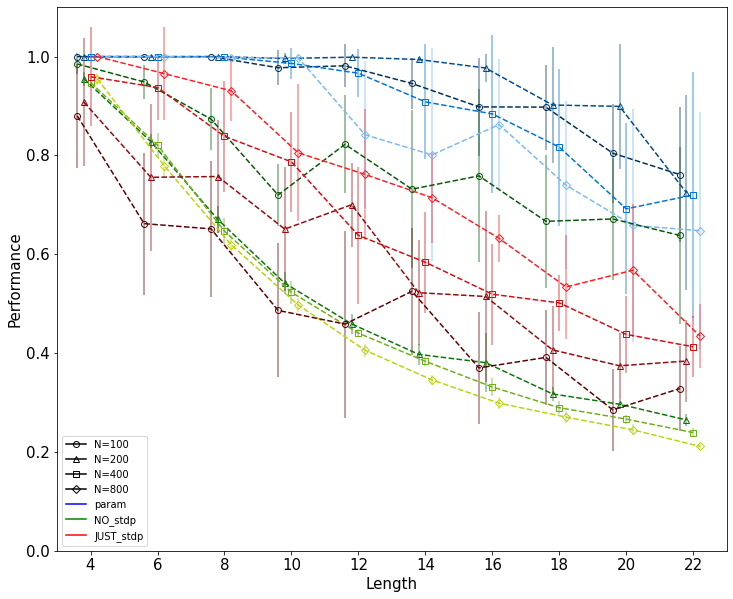

In [15]:
plotty3("exp3_param", "exp3_NO_stdp", "exp3_JUST_stdp")


Calculating performance for the Counting Task...
experiment exp3_param N100_L4_1 ... Performance - LR: 1.00
experiment exp3_param N100_L4_2 ... Performance - LR: 1.00
experiment exp3_param N100_L4_3 ... Performance - LR: 1.00
experiment exp3_param N100_L4_4 ... Performance - LR: 1.00
experiment exp3_param N100_L4_5 ... Performance - LR: 1.00
experiment exp3_param N100_L4_6 ... Performance - LR: 1.00
experiment exp3_param N100_L4_7 ... Performance - LR: 1.00
experiment exp3_param N100_L4_8 ... Performance - LR: 1.00
experiment exp3_param N100_L4_9 ... Performance - LR: 1.00
experiment exp3_param N100_L4_10 ... Performance - LR: 1.00
experiment exp3_param N100_L6_1 ... Performance - LR: 1.00
experiment exp3_param N100_L6_2 ... Performance - LR: 1.00
experiment exp3_param N100_L6_3 ... Performance - LR: 1.00
experiment exp3_param N100_L6_4 ... Performance - LR: 1.00
experiment exp3_param N100_L6_5 ... Performance - LR: 1.00
experiment exp3_param N100_L6_6 ... Performance - LR: 1.00
exper

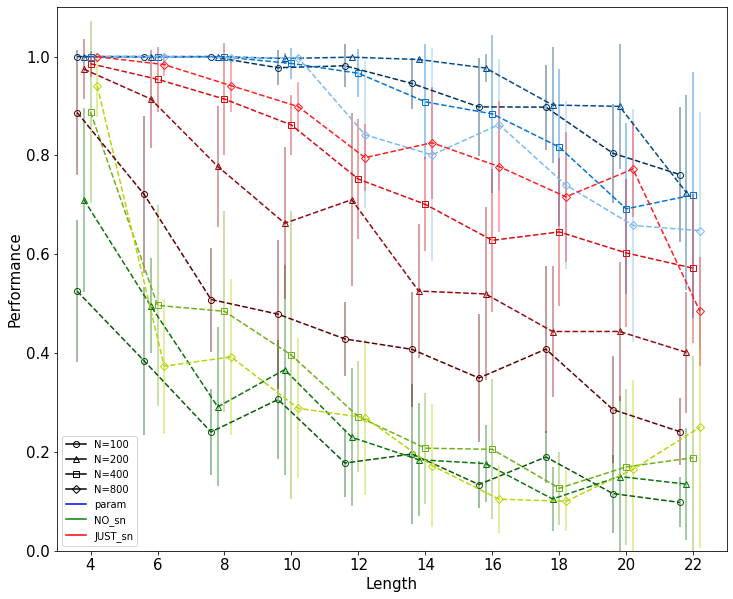

In [16]:
plotty3("exp3_param", "exp3_NO_sn", "exp3_JUST_sn")


Calculating performance for the Counting Task...
experiment exp3_param N100_L4_1 ... Performance - LR: 1.00
experiment exp3_param N100_L4_2 ... Performance - LR: 1.00
experiment exp3_param N100_L4_3 ... Performance - LR: 1.00
experiment exp3_param N100_L4_4 ... Performance - LR: 1.00
experiment exp3_param N100_L4_5 ... Performance - LR: 1.00
experiment exp3_param N100_L4_6 ... Performance - LR: 1.00
experiment exp3_param N100_L4_7 ... Performance - LR: 1.00
experiment exp3_param N100_L4_8 ... Performance - LR: 1.00
experiment exp3_param N100_L4_9 ... Performance - LR: 1.00
experiment exp3_param N100_L4_10 ... Performance - LR: 1.00
experiment exp3_param N100_L6_1 ... Performance - LR: 1.00
experiment exp3_param N100_L6_2 ... Performance - LR: 1.00
experiment exp3_param N100_L6_3 ... Performance - LR: 1.00
experiment exp3_param N100_L6_4 ... Performance - LR: 1.00
experiment exp3_param N100_L6_5 ... Performance - LR: 1.00
experiment exp3_param N100_L6_6 ... Performance - LR: 1.00
exper

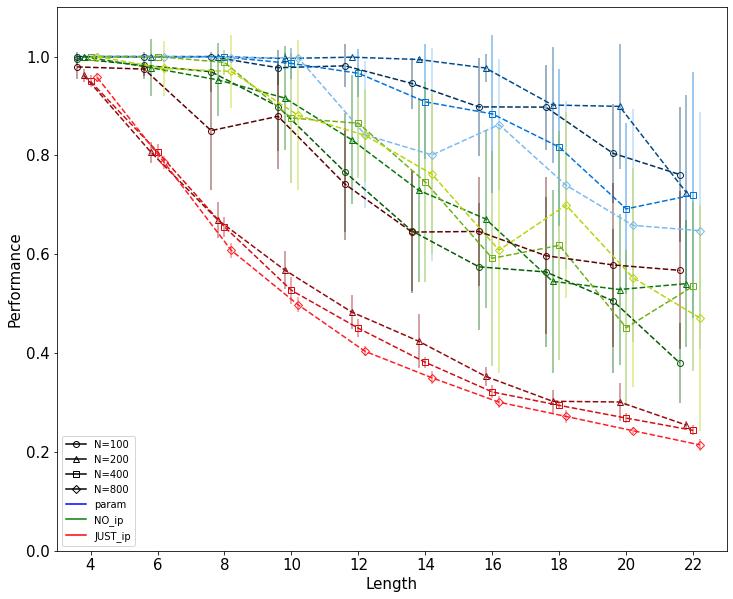

In [17]:
plotty3("exp3_param", "exp3_NO_ip", "exp3_JUST_ip")